# EuroSat Image Classification using Vision Transformer (ViT)

Hector Becerra  
Juan Terven  
2023

The **Vision Transformer (ViT)** is a pioneering neural network architecture introduced by Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, and others in 2020, which adapts the Transformer model, originally designed for natural language processing, for image classification tasks. In ViT, an input image is divided into fixed-size patches, and these patches are linearly embedded, along with positional encodings, to retain spatial information. These embeddings are then processed through multiple layers of self-attention and feed-forward neural networks, akin to the Transformer architecture used in language models. ViT marked a significant departure from conventional convolutional neural networks by relying solely on attention mechanisms, demonstrating that Transformers could achieve state-of-the-art performance in computer vision tasks without convolutional layers. This paradigm shift has sparked extensive research and development in applying Transformer architectures to a broader range of visual data processing tasks.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import vit_l_32,ViT_L_32_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.13.1+cu117


## Login to Wandb to log experiment

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_ResNeXt_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "C:/Users/jrtervens/Documents/data/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Check the transformations used in the pre-trained model
weights = ViT_L_32_Weights.DEFAULT
preprocess = weights.transforms()
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((256,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((224, 224)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 32  # The batch size for training data.
val_batch = 8     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

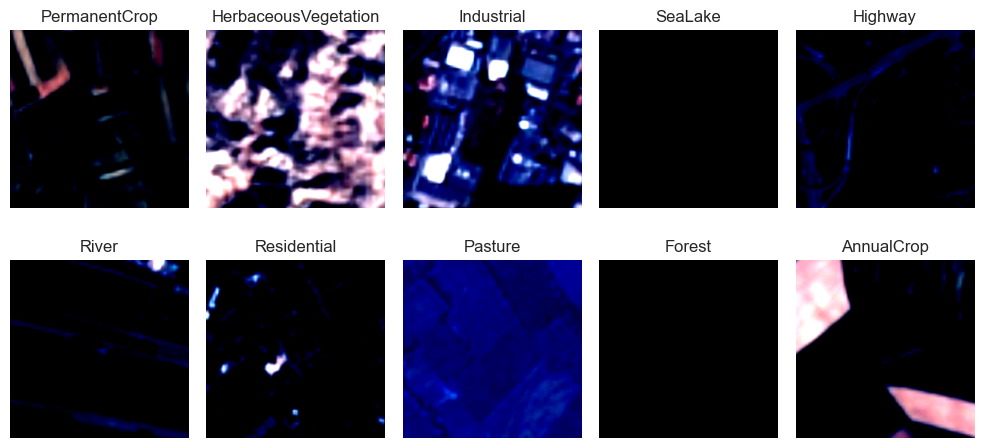

In [9]:
visualize_classes(train_loader, index_to_label)

In [10]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 591
Validation set batches: 675
Test set examples: 2700


## Labels distribution

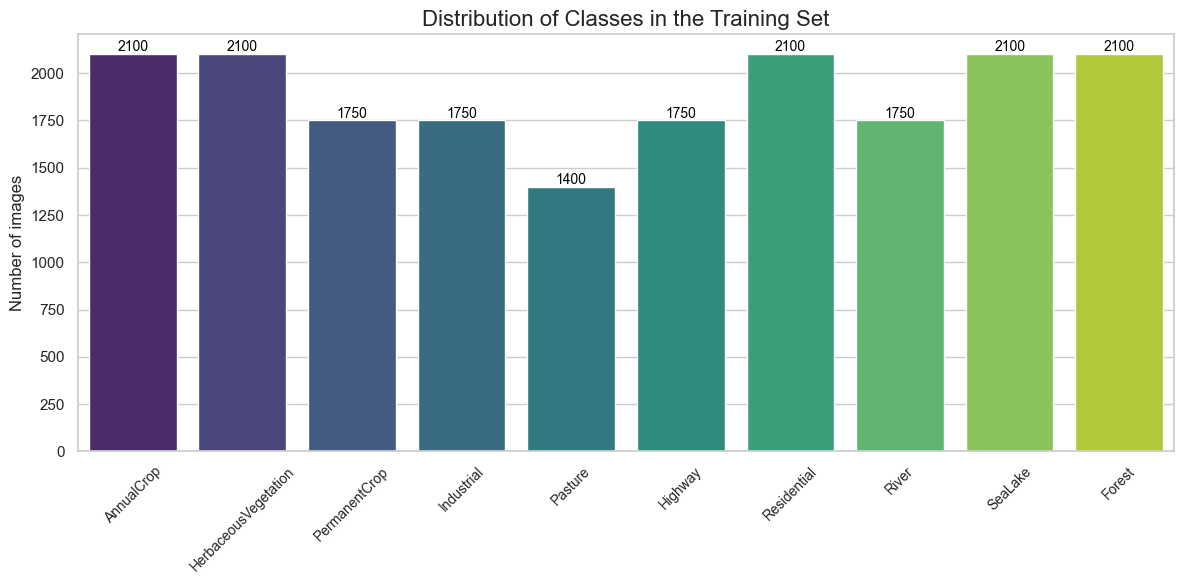

In [11]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [12]:
# Use un-pretrained model
model = vit_l_32()

# Replace the model head with the number of classes
num_classes = 10
model.heads.head = nn.Linear(1024, num_classes) 
model.to(DEVICE)

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

# Training model from Scratch

In [14]:
project_name = "EuroSAT"
model_name = "ViT32"
models_path = "C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/"

In [27]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ViT32 from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 591 steps.

Epoch: 1...
Step: 21/591 Loss: 2.622403007745743
Step: 41/591 Loss: 1.8800465285778045
Step: 61/591 Loss: 1.7925933122634887
Step: 81/591 Loss: 1.6922483623027802
Step: 101/591 Loss: 1.5678161978721619
Step: 121/591 Loss: 1.5295937478542327
Step: 141/591 Loss: 1.4250414192676544
Step: 161/591 Loss: 1.3875993877649306
Step: 181/591 Loss: 1.2494165867567062
Step: 201/591 Loss: 1.3049710810184478
Step: 221/591 Loss: 1.3033841699361801
Step: 241/591 Loss: 1.261714470386505
Step: 261/591 Loss: 1.2317468345165252
Step: 281/591 Loss: 1.1640162110328673
Step: 301/591 Loss: 1.183530268073082
Step: 321/591 Loss: 0.9607068449258804
Step: 341/591 Loss: 0.9733401864767075
Step: 361/591 Loss: 1.0208108693361282
Step: 381/591 Loss: 1.1646807879209518
Step: 401/591 Loss: 1.0532038718461991
Step: 421/591 Loss: 0.9382610619068146
Step: 441/591 Loss: 0.9322047352790832
Step: 461/591 Loss: 0.8632791221141816
Step: 481/591 Loss

Step: 461/591 Loss: 0.3683098629117012
Step: 481/591 Loss: 0.4308703012764454
Step: 501/591 Loss: 0.3239496950060129
Step: 521/591 Loss: 0.407666389644146
Step: 541/591 Loss: 0.44381803572177886
Step: 561/591 Loss: 0.44013859182596204
Step: 581/591 Loss: 0.41485121846199036
Validation Loss: 0.4392 Accuracy: 0.8483
Epoch duration: 267.49s

Epoch: 8...
Step: 21/591 Loss: 0.381509305909276
Step: 41/591 Loss: 0.39204198196530343
Step: 61/591 Loss: 0.38624367825686934
Step: 81/591 Loss: 0.3733843892812729
Step: 101/591 Loss: 0.3556524276733398
Step: 121/591 Loss: 0.40609154514968393
Step: 141/591 Loss: 0.3940684165805578
Step: 161/591 Loss: 0.385796333104372
Step: 181/591 Loss: 0.42187655828893184
Step: 201/591 Loss: 0.411548013985157
Step: 221/591 Loss: 0.41030969843268394
Step: 241/591 Loss: 0.4142384298145771
Step: 261/591 Loss: 0.3783923707902431
Step: 281/591 Loss: 0.3922389790415764
Step: 301/591 Loss: 0.495071417838335
Step: 321/591 Loss: 0.46553904563188553
Step: 341/591 Loss: 0.406

Step: 301/591 Loss: 0.27032570727169514
Step: 321/591 Loss: 0.2885658986866474
Step: 341/591 Loss: 0.29080727994441985
Step: 361/591 Loss: 0.3382148779928684
Step: 381/591 Loss: 0.2986111681908369
Step: 401/591 Loss: 0.2819097347557545
Step: 421/591 Loss: 0.3112557418644428
Step: 441/591 Loss: 0.30535564497113227
Step: 461/591 Loss: 0.30675820261240005
Step: 481/591 Loss: 0.3043624050915241
Step: 501/591 Loss: 0.28694515153765676
Step: 521/591 Loss: 0.30706029012799263
Step: 541/591 Loss: 0.282719562202692
Step: 561/591 Loss: 0.33301209285855293
Step: 581/591 Loss: 0.36958084516227246
Validation Loss: 0.3484 Accuracy: 0.8806
Epoch duration: 267.83s

Epoch: 15...
Step: 21/591 Loss: 0.28040100298821924
Step: 41/591 Loss: 0.2542040809988976
Step: 61/591 Loss: 0.2804400403052568
Step: 81/591 Loss: 0.3065796509385109
Step: 101/591 Loss: 0.28259030990302564
Step: 121/591 Loss: 0.297296255081892
Step: 141/591 Loss: 0.3567353770136833
Step: 161/591 Loss: 0.281963574513793
Step: 181/591 Loss: 0

Step: 141/591 Loss: 0.1913254089653492
Step: 161/591 Loss: 0.2230648383498192
Step: 181/591 Loss: 0.17708994671702386
Step: 201/591 Loss: 0.1773888467811048
Step: 221/591 Loss: 0.22315042316913605
Step: 241/591 Loss: 0.22758352663367987
Step: 261/591 Loss: 0.20404076119884848
Step: 281/591 Loss: 0.2385787069797516
Step: 301/591 Loss: 0.2155049264431
Step: 321/591 Loss: 0.2611394807696342
Step: 341/591 Loss: 0.22093227729201317
Step: 361/591 Loss: 0.2203409940004349
Step: 381/591 Loss: 0.2318355830386281
Step: 401/591 Loss: 0.15573501028120518
Step: 421/591 Loss: 0.23213966861367225
Step: 441/591 Loss: 0.2688547395169735
Step: 461/591 Loss: 0.22523524314165116
Step: 481/591 Loss: 0.21273071486502887
Step: 501/591 Loss: 0.2139697538688779
Step: 521/591 Loss: 0.2147289365530014
Step: 541/591 Loss: 0.22229744270443916
Step: 561/591 Loss: 0.19818459497764707
Step: 581/591 Loss: 0.2589666623622179
Validation Loss: 0.3403 Accuracy: 0.8822
Epoch duration: 270.26s

Epoch: 22...
Step: 21/591 Los

Step: 581/591 Loss: 0.1925181346014142
Validation Loss: 0.3115 Accuracy: 0.8959
Epoch duration: 266.85s

Epoch: 28...
Step: 21/591 Loss: 0.11873960439115763
Step: 41/591 Loss: 0.17387513034045696
Step: 61/591 Loss: 0.11935936603695155
Step: 81/591 Loss: 0.11939525799825787
Step: 101/591 Loss: 0.07927285931073129
Step: 121/591 Loss: 0.11903767045587302
Step: 141/591 Loss: 0.16356804827228189
Step: 161/591 Loss: 0.1518389407545328
Step: 181/591 Loss: 0.18504482470452785
Step: 201/591 Loss: 0.14271575715392829
Step: 221/591 Loss: 0.1171273703686893
Step: 241/591 Loss: 0.1607503453269601
Step: 261/591 Loss: 0.15625213086605072
Step: 281/591 Loss: 0.15316266678273677
Step: 301/591 Loss: 0.13308318331837654
Step: 321/591 Loss: 0.15511794313788413
Step: 341/591 Loss: 0.18276818953454493
Step: 361/591 Loss: 0.16393144438043236
Step: 381/591 Loss: 0.15538115967065097
Step: 401/591 Loss: 0.14627739060670136
Step: 421/591 Loss: 0.15686473604291679
Step: 441/591 Loss: 0.21403734125196933
Step: 461

Step: 381/591 Loss: 0.0901631481014192
Step: 401/591 Loss: 0.11376900337636471
Step: 421/591 Loss: 0.11198746170848609
Step: 441/591 Loss: 0.14907309226691723
Step: 461/591 Loss: 0.12777374489232898
Step: 481/591 Loss: 0.08353949496522546
Step: 501/591 Loss: 0.11426075994968414
Step: 521/591 Loss: 0.11306948503479361
Step: 541/591 Loss: 0.1369660991244018
Step: 561/591 Loss: 0.13790469970554114
Step: 581/591 Loss: 0.14103833436965943
Validation Loss: 0.3168 Accuracy: 0.9011
Epoch duration: 266.32s

Epoch: 35...
Step: 21/591 Loss: 0.09880070481449366
Step: 41/591 Loss: 0.08605650814715773
Step: 61/591 Loss: 0.11618359093554317
Step: 81/591 Loss: 0.14138770001009107
Step: 101/591 Loss: 0.07174268974922597
Step: 121/591 Loss: 0.06418871516361832
Step: 141/591 Loss: 0.08198046644683928
Step: 161/591 Loss: 0.05919907453935593
Step: 181/591 Loss: 0.07860498493537307
Step: 201/591 Loss: 0.08758988995105028
Step: 221/591 Loss: 0.10869568707421422
Step: 241/591 Loss: 0.09169249115511775
Step: 2

Step: 181/591 Loss: 0.14850183599628508
Step: 201/591 Loss: 0.08492014738731087
Step: 221/591 Loss: 0.08765204665251076
Step: 241/591 Loss: 0.07606994328089059
Step: 261/591 Loss: 0.06839677421376109
Step: 281/591 Loss: 0.08332265061326324
Step: 301/591 Loss: 0.07419962184503674
Step: 321/591 Loss: 0.06920005141291767
Step: 341/591 Loss: 0.07098741078516468
Step: 361/591 Loss: 0.097502376511693
Step: 381/591 Loss: 0.09756556553766131
Step: 401/591 Loss: 0.10420612911693752
Step: 421/591 Loss: 0.10721165225841105
Step: 441/591 Loss: 0.10876663392409683
Step: 461/591 Loss: 0.13616157514043153
Step: 481/591 Loss: 0.10457489853724837
Step: 501/591 Loss: 0.09486429211683571
Step: 521/591 Loss: 0.10101794642396271
Step: 541/591 Loss: 0.09698715130798519
Step: 561/591 Loss: 0.10264202682301402
Step: 581/591 Loss: 0.11445879470556974
Validation Loss: 0.3139 Accuracy: 0.9041
Epoch duration: 271.15s

Epoch: 42...
Step: 21/591 Loss: 0.052848533540964124
Step: 41/591 Loss: 0.05819059687200934
Step

Step: 581/591 Loss: 0.09704760108143091
Validation Loss: 0.3366 Accuracy: 0.9054
Epoch duration: 270.60s

Epoch: 48...
Step: 21/591 Loss: 0.053481545322574674
Step: 41/591 Loss: 0.04183600172400474
Step: 61/591 Loss: 0.10521680284291506
Step: 81/591 Loss: 0.07933834306895733
Step: 101/591 Loss: 0.07170856762677431
Step: 121/591 Loss: 0.04138909443281591
Step: 141/591 Loss: 0.0761836941121146
Step: 161/591 Loss: 0.06286085974425078
Step: 181/591 Loss: 0.04934019384090789
Step: 201/591 Loss: 0.04349361885106191
Step: 221/591 Loss: 0.057075140182860196
Step: 241/591 Loss: 0.059213483007624745
Step: 261/591 Loss: 0.047415256395470354
Step: 281/591 Loss: 0.06510568221565335
Step: 301/591 Loss: 0.05057097610551864
Step: 321/591 Loss: 0.054111727065173906
Step: 341/591 Loss: 0.07057543590199203
Step: 361/591 Loss: 0.09908496551215648
Step: 381/591 Loss: 0.07151880692690611
Step: 401/591 Loss: 0.1115691829007119
Step: 421/591 Loss: 0.1073972400277853
Step: 441/591 Loss: 0.06933617022586987
Ste

Step: 361/591 Loss: 0.069570329610724
Step: 381/591 Loss: 0.04982003478799015
Step: 401/591 Loss: 0.05293276635929942
Step: 421/591 Loss: 0.036479941656580195
Step: 441/591 Loss: 0.04723686874494888
Step: 461/591 Loss: 0.04418362460564822
Step: 481/591 Loss: 0.03783731783041731
Step: 501/591 Loss: 0.05332886118849274
Step: 521/591 Loss: 0.06343888421542943
Step: 541/591 Loss: 0.08548331039492041
Step: 561/591 Loss: 0.06621248775627464
Step: 581/591 Loss: 0.06480385980685241
Validation Loss: 0.3510 Accuracy: 0.9096
Epoch duration: 266.14s

Epoch: 55...
Step: 21/591 Loss: 0.03366092256037519
Step: 41/591 Loss: 0.06801519395085051
Step: 61/591 Loss: 0.0485412164562149
Step: 81/591 Loss: 0.03312170576537028
Step: 101/591 Loss: 0.04148117911536246
Step: 121/591 Loss: 0.031010346772382034
Step: 141/591 Loss: 0.0379088154877536
Step: 161/591 Loss: 0.053959742945153266
Step: 181/591 Loss: 0.0633720176294446
Step: 201/591 Loss: 0.030146298499312253
Step: 221/591 Loss: 0.058969285240164024
Step:

Step: 121/591 Loss: 0.025187650683801622
Step: 141/591 Loss: 0.010869506013114006
Step: 161/591 Loss: 0.03063213518616976
Step: 181/591 Loss: 0.026332352789177095
Step: 201/591 Loss: 0.01951890456257388
Step: 221/591 Loss: 0.02006806205608882
Step: 241/591 Loss: 0.027563136094249784
Step: 261/591 Loss: 0.0719010503438767
Step: 281/591 Loss: 0.04482428485061973
Step: 301/591 Loss: 0.04589939798170235
Step: 321/591 Loss: 0.023741738591343164
Step: 341/591 Loss: 0.04534532678080723
Step: 361/591 Loss: 0.06430020090192556
Step: 381/591 Loss: 0.05157002516789362
Step: 401/591 Loss: 0.06589883936103433
Step: 421/591 Loss: 0.05105899514164776
Step: 441/591 Loss: 0.08118214197456837
Step: 461/591 Loss: 0.0906239127740264
Step: 481/591 Loss: 0.05273273144848645
Step: 501/591 Loss: 0.05363478816580027
Step: 521/591 Loss: 0.06792706924024969
Step: 541/591 Loss: 0.043149249628186226
Step: 561/591 Loss: 0.05926089864224195
Step: 581/591 Loss: 0.041995734069496395
Validation Loss: 0.3332 Accuracy: 0

## Save model

In [28]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\ViT32.pth


In [29]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

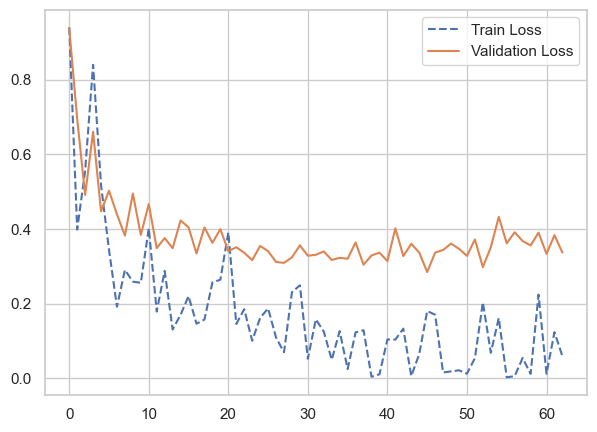

In [30]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [31]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [15]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/ViT32.pth


<All keys matched successfully>

In [16]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.902     0.917     0.909       300
              Forest      0.977     0.990     0.983       300
HerbaceousVegetation      0.897     0.897     0.897       300
             Highway      0.888     0.796     0.840       250
          Industrial      0.920     0.964     0.941       250
             Pasture      0.923     0.835     0.877       200
       PermanentCrop      0.828     0.888     0.857       250
         Residential      0.948     0.980     0.964       300
               River      0.875     0.900     0.888       250
             SeaLake      0.997     0.960     0.978       300

            accuracy                          0.917      2700
           macro avg      0.915     0.913     0.913      2700
        weighted avg      0.918     0.917     0.917      2700



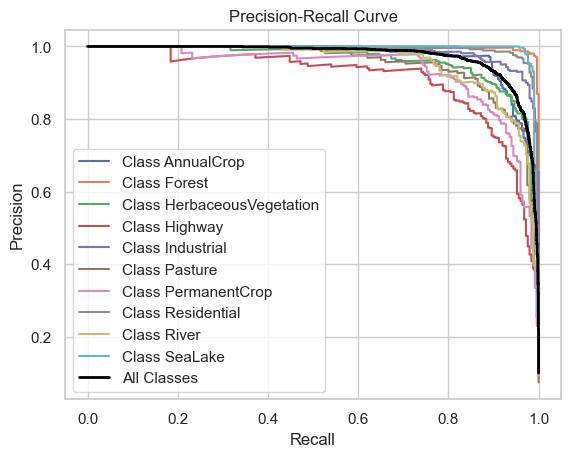

In [33]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [34]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▅▅▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇▇▇▆▆▆▇▇▇▇▇▇▇▇▇██▇██▇███████▇█████
val_loss,█▅▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▂▁▁▂▂▂▂▁▂
epoch,62
step,37222
train_loss,0.05565
val_accuracy,0.90981
val_loss,0.33668


## Load the precision/recall curve and plot it

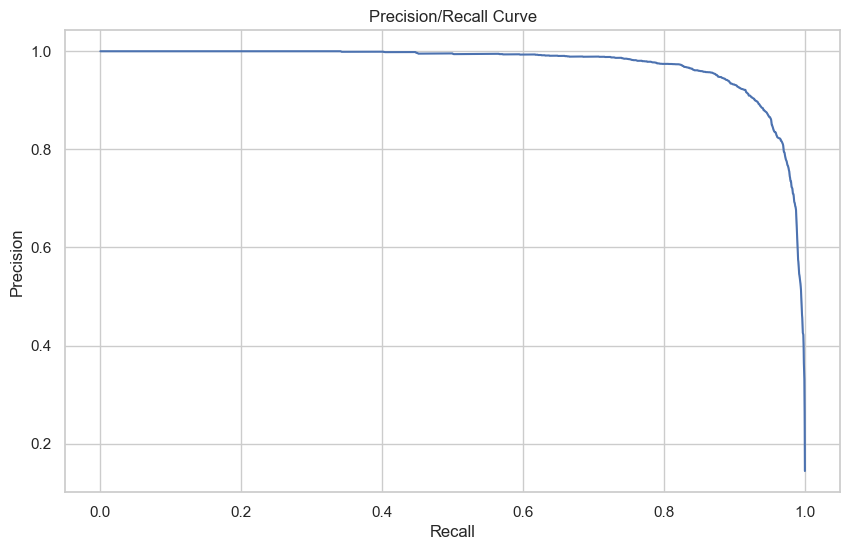

In [35]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [17]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


26965

# Now train the model with pre-trained weights

In [18]:
# Use pretrained model
model2 = vit_l_32(weights=ViT_L_32_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.heads.head = nn.Linear(1024, num_classes) 
model2.to(DEVICE)

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

## Train with pre-trained weights

In [19]:
model_name = "ViT32-Pretrained"

In [39]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="ViT32 pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 591 steps.

Epoch: 1...
Step: 21/591 Loss: 0.9762567549943924
Step: 41/591 Loss: 0.3474425382912159
Step: 61/591 Loss: 0.2393144192174077
Step: 81/591 Loss: 0.2194447247311473
Step: 101/591 Loss: 0.19572300724685193
Step: 121/591 Loss: 0.19638067223131656
Step: 141/591 Loss: 0.2215060146525502
Step: 161/591 Loss: 0.1577697589993477
Step: 181/591 Loss: 0.17699187006801367
Step: 201/591 Loss: 0.21709834672510625
Step: 221/591 Loss: 0.19292889554053544
Step: 241/591 Loss: 0.1846088904887438
Step: 261/591 Loss: 0.1588658457621932
Step: 281/591 Loss: 0.154608535207808
Step: 301/591 Loss: 0.2223818906582892
Step: 321/591 Loss: 0.16205594949424268
Step: 341/591 Loss: 0.18376472778618336
Step: 361/591 Loss: 0.25374312568455937
Step: 381/591 Loss: 0.12126316949725151
Step: 401/591 Loss: 0.09427432278171181
Step: 421/591 Loss: 0.11808200776576996
Step: 441/591 Loss: 0.11752560497261584
Step: 461/591 Loss: 0.13548197988420724
Ste

Step: 381/591 Loss: 0.06314802822598722
Step: 401/591 Loss: 0.022614044940564782
Step: 421/591 Loss: 0.009706411793013103
Step: 441/591 Loss: 0.017103840297204444
Step: 461/591 Loss: 0.0156237373535987
Step: 481/591 Loss: 0.027823773967975286
Step: 501/591 Loss: 0.023479407865670508
Step: 521/591 Loss: 0.021795087773352862
Step: 541/591 Loss: 0.036768975801533085
Step: 561/591 Loss: 0.027116884480346926
Step: 581/591 Loss: 0.026643655583029613
Validation Loss: 0.1362 Accuracy: 0.9630
Epoch duration: 270.25s

Epoch: 8...
Step: 21/591 Loss: 0.04397814597468823
Step: 41/591 Loss: 0.035226629523094743
Step: 61/591 Loss: 0.0837901015765965
Step: 81/591 Loss: 0.041262540477328004
Step: 101/591 Loss: 0.041712001420091835
Step: 121/591 Loss: 0.06299564055516385
Step: 141/591 Loss: 0.04550359596032649
Step: 161/591 Loss: 0.041702642582822594
Step: 181/591 Loss: 0.0663897201535292
Step: 201/591 Loss: 0.05688467861618847
Step: 221/591 Loss: 0.05045697421301156
Step: 241/591 Loss: 0.03054690691642

Step: 121/591 Loss: 0.035699009656673296
Step: 141/591 Loss: 0.025128578828298487
Step: 161/591 Loss: 0.008043318302952684
Step: 181/591 Loss: 0.02066217040846823
Step: 201/591 Loss: 0.021346937169437297
Step: 221/591 Loss: 0.033459757216041906
Step: 241/591 Loss: 0.009182683131075463
Step: 261/591 Loss: 0.013693328283261507
Step: 281/591 Loss: 0.03205636860366212
Step: 301/591 Loss: 0.027396816009422766
Step: 321/591 Loss: 0.02420768343145028
Step: 341/591 Loss: 0.009169277887849603
Step: 361/591 Loss: 0.009521506473538466
Step: 381/591 Loss: 0.0095133644528687
Step: 401/591 Loss: 0.028598169360338942
Step: 421/591 Loss: 0.010147169450647198
Step: 441/591 Loss: 0.021167716677882708
Step: 461/591 Loss: 0.02263932565692812
Step: 481/591 Loss: 0.01944013585016364
Step: 501/591 Loss: 0.01804604957869742
Step: 521/591 Loss: 0.04198246706509963
Step: 541/591 Loss: 0.017946365231182426
Step: 561/591 Loss: 0.013904356834245846
Step: 581/591 Loss: 0.02614851058460772
Validation Loss: 0.1410 Ac

## Save model

In [40]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\ViT32-Pretrained.pth


In [41]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

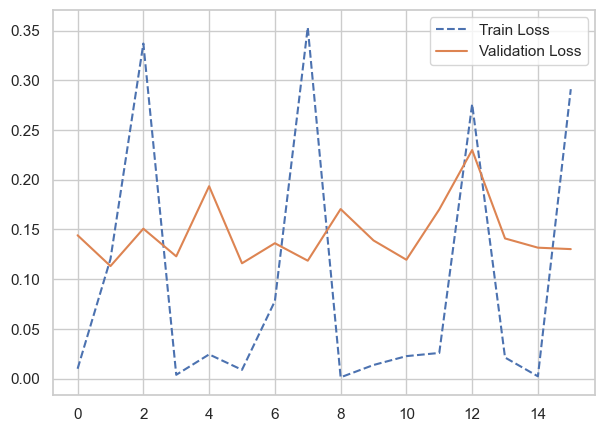

In [42]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [43]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [20]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + f"{model_name}.pth"
print(f"Loading model {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading model C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/ViT32-Pretrained.pth


<All keys matched successfully>

In [21]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.967     0.987     0.977       300
              Forest      0.997     0.987     0.992       300
HerbaceousVegetation      0.930     0.970     0.949       300
             Highway      0.950     0.988     0.969       250
          Industrial      0.965     0.996     0.980       250
             Pasture      0.990     0.945     0.967       200
       PermanentCrop      0.950     0.912     0.931       250
         Residential      1.000     0.983     0.992       300
               River      0.976     0.960     0.968       250
             SeaLake      0.997     0.977     0.987       300

            accuracy                          0.972      2700
           macro avg      0.972     0.970     0.971      2700
        weighted avg      0.972     0.972     0.972      2700



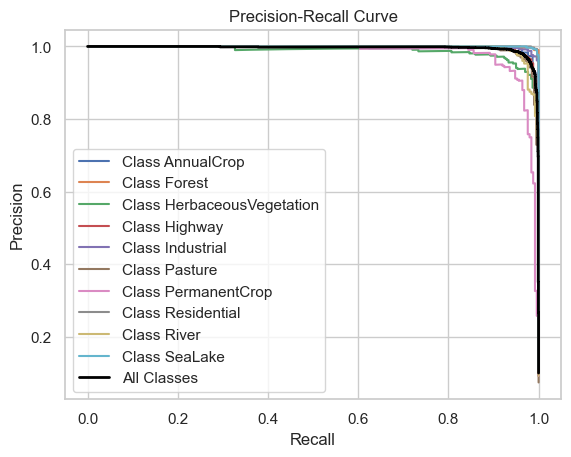

In [45]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [46]:
wandb.finish()

epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▇▅▄▃▂▄▄▃▂▂▂▃▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▂▂▁▂▂▁▂▂▁▂▁
val_accuracy,▄▇▅█▁█▇█▅▇▇▅▁▇▇█
val_loss,▃▁▃▂▆▁▂▁▄▃▁▄█▃▂▂
epoch,15
step,9445
train_loss,0.00682
val_accuracy,0.965
val_loss,0.13027


In [22]:
del model2
torch.cuda.empty_cache()
gc.collect()

18